In [15]:
# Stock Recommendation Sentiment Labeling
# Labels: Positive = Stock Increase, Negative = Stock Decrease, Neutral = Mixed/Uncertain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load your CSV file
print("=== Loading Dataset ===")
# Replace 'your_file.csv' with your actual file path
file_path = '../Data/NLP/news_dataset_id2.csv'  # Change this to your file path

try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Check if expected columns exist
    expected_columns = ['title', 'description', 'content', 'publishedAt', 'url']
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        print(f"Warning: Missing columns: {missing_columns}")
    
except FileNotFoundError:
    print("File not found. Creating sample data for demonstration...")
    # Sample stock-related data for demonstration
    sample_data = {
        'title': [
            "Apple Stock Surges on Strong Earnings",
            "Tesla Faces Major Decline After Poor Report", 
            "Microsoft Holds Steady Amid Market Volatility",
            "Amazon Shows Bullish Momentum in Q4",
            "Netflix Stock Crashes Following Subscriber Loss"
        ],
        'description': [
            "Apple reports record quarterly earnings beating expectations",
            "Tesla stock drops 15% after missing revenue targets significantly", 
            "Microsoft maintains position with mixed quarterly results",
            "Amazon exceeds profit forecasts driving stock higher",
            "Netflix loses subscribers causing major sell-off"
        ],
        'content': [
            "Strong buy recommendation. Apple stock expected to rise 20% next quarter based on iPhone sales.",
            "Sell immediately. Tesla facing major losses and declining revenue in key markets.",
            "Hold position. Mixed signals in Microsoft stock, uncertain direction ahead.",
            "Bullish outlook on Amazon. Great earnings report, stock will likely surge to new highs.",
            "Bearish trend continues for Netflix. Recommend selling before further decline."
        ],
        'publishedAt': ['2024-01-15', '2024-01-14', '2024-01-13', '2024-01-12', '2024-01-11'],
        'url': ['url1.com', 'url2.com', 'url3.com', 'url4.com', 'url5.com']
    }
    df = pd.DataFrame(sample_data)
    print("Using sample data for demonstration.")

=== Loading Dataset ===
Dataset loaded successfully!
Shape: (675, 5)
Columns: ['title', 'description', 'content', 'publishedAt', 'url']

First few rows:
                                               title  \
0            Energy Stocks Worth Watching – May 30th   
1  Still In The Factory Crate! A Brand New 1967 M...   
2  Auto Trader Group (LON:AUTO) Trading Down 11.3...   
3  Varonis Systems (NASDAQ:VRNS) and Cadence Desi...   
4               5G Stocks To Follow Today – May 30th   

                                         description  \
0  Tesla, AltC Acquisition, Broadcom, Oklo, GE Ve...   
1  This is a brand new, never used body shell for...   
2  Auto Trader Group plc (LON:AUTO – Get Free Rep...   
3  Varonis Systems (NASDAQ:VRNS – Get Free Report...   
4  Super Micro Computer, QUALCOMM, Cisco Systems,...   

                                             content           publishedAt  \
0  Tesla, AltC Acquisition, Broadcom, Oklo, GE Ve...  2025-06-01T06:36:44Z   
1  This is a bran

In [17]:
# Combine text columns for comprehensive analysis
def combine_text_fields(row):
    """Combine title, description, and content for analysis"""
    combined_text = ""
    
    # Add title (usually most important)
    if pd.notna(row.get('title')):
        combined_text += str(row['title']) + " "
    
    # Add description 
    if pd.notna(row.get('description')):
        combined_text += str(row['description']) + " "
    
    # Add content (might be longest)
    if pd.notna(row.get('content')):
        combined_text += str(row['content'])
    
    return combined_text.strip()

print("\n=== Combining Text Fields ===")
df['combined_text'] = df.apply(combine_text_fields, axis=1)
print(f"Combined text created for {len(df)} rows")


=== Combining Text Fields ===
Combined text created for 675 rows


In [18]:
# Show sample of combined text
print(f"\nSample combined text:")
print(f"Row 1: {df['combined_text'].iloc[0][:150]}...")


Sample combined text:
Row 1: Energy Stocks Worth Watching – May 30th Tesla, AltC Acquisition, Broadcom, Oklo, GE Vernova, Exxon Mobil, and Chevron are the seven Energy stocks to w...


In [19]:
# Stock-specific sentiment analysis function
def get_stock_sentiment(text):
    """
    Analyze text for stock recommendation sentiment
    Positive = Stock increase/buy signals
    Negative = Stock decrease/sell signals  
    Neutral = Mixed/uncertain signals
    """
    if pd.isna(text) or text.strip() == "":
        return 'Neutral'
        
    text_lower = text.lower()
    
    # Define stock-specific keywords
    positive_keywords = [
        'buy', 'bullish', 'bull', 'rise', 'increase', 'gain', 'surge', 'growth', 
        'strong', 'excellent', 'outperform', 'upgrade', 'target price up',
        'revenue growth', 'profit', 'earnings beat', 'positive', 'recommend buy',
        'uptrend', 'momentum', 'rally', 'breakout', 'support level', 'beat expectations',
        'record earnings', 'higher', 'soar', 'jump', 'climb'
    ]
    
    negative_keywords = [
        'sell', 'bearish', 'bear', 'fall', 'decrease', 'decline', 'drop', 'loss',
        'weak', 'poor', 'underperform', 'downgrade', 'target price down',
        'revenue decline', 'losses', 'earnings miss', 'negative', 'recommend sell',
        'downtrend', 'resistance', 'crash', 'correction', 'avoid', 'miss expectations',
        'disappointing', 'lower', 'plunge', 'tumble', 'sink'
    ]
    
    neutral_keywords = [
        'hold', 'neutral', 'wait', 'uncertain', 'mixed', 'sideways', 'range',
        'consolidation', 'watch', 'monitor', 'cautious', 'moderate', 'steady',
        'stable', 'maintain'
    ]
    
    # Count keyword occurrences
    pos_score = sum(1 for word in positive_keywords if word in text_lower)
    neg_score = sum(1 for word in negative_keywords if word in text_lower)
    neu_score = sum(1 for word in neutral_keywords if word in text_lower)
    
    # Use TextBlob as additional signal
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    # Combine keyword analysis with TextBlob
    total_pos = pos_score + (1 if polarity > 0.2 else 0)
    total_neg = neg_score + (1 if polarity < -0.2 else 0)
    total_neu = neu_score + (1 if -0.2 <= polarity <= 0.2 else 0)
    
    # Determine final sentiment
    if total_pos > total_neg and total_pos > total_neu:
        return 'Positive'  # Stock increase
    elif total_neg > total_pos and total_neg > total_neu:
        return 'Negative'  # Stock decrease
    else:
        return 'Neutral'   # Mixed/uncertain

def get_confidence_score(text):
    """Calculate confidence score for the sentiment prediction"""
    if pd.isna(text) or text.strip() == "":
        return 0.0
        
    text_lower = text.lower()
    
    # Strong indicators
    strong_positive = ['strong buy', 'excellent', 'surge', 'bullish', 'target price up', 
                      'beat expectations', 'record earnings']
    strong_negative = ['strong sell', 'avoid', 'crash', 'bearish', 'target price down',
                      'miss expectations', 'disappointing']
    
    strong_pos_count = sum(1 for phrase in strong_positive if phrase in text_lower)
    strong_neg_count = sum(1 for phrase in strong_negative if phrase in text_lower)
    
    # TextBlob confidence
    polarity_strength = abs(TextBlob(text).sentiment.polarity)
    
    # Calculate overall confidence
    confidence = min(1.0, (strong_pos_count + strong_neg_count + polarity_strength))
    return round(confidence, 3)

In [20]:
# Apply sentiment analysis
print("\n=== Applying Stock Sentiment Analysis ===")
df['stock_sentiment'] = df['combined_text'].apply(get_stock_sentiment)
df['confidence_score'] = df['combined_text'].apply(get_confidence_score)
df['polarity_score'] = df['combined_text'].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notna(x) and x.strip() != "" else 0)


=== Applying Stock Sentiment Analysis ===


In [21]:
# Display results
print("\nSentiment Analysis Results:")
print("=" * 120)
for idx, row in df.iterrows():
    print(f"Title: {row.get('title', 'N/A')}")
    if pd.notna(row.get('description')) and row['description'].strip():
        desc_preview = row['description'][:100] + "..." if len(str(row['description'])) > 100 else row['description']
        print(f"Description: {desc_preview}")
    print(f"Stock Sentiment: {row['stock_sentiment']} (Confidence: {row['confidence_score']:.3f})")
    print(f"Polarity Score: {row['polarity_score']:.3f}")
    print(f"Published: {row.get('publishedAt', 'N/A')}")
    print("-" * 120)


Sentiment Analysis Results:
Title: Energy Stocks Worth Watching – May 30th
Description: Tesla, AltC Acquisition, Broadcom, Oklo, GE Vernova, Exxon Mobil, and Chevron are the seven Energy s...
Stock Sentiment: Neutral (Confidence: 0.300)
Polarity Score: 0.300
Published: 2025-06-01T06:36:44Z
------------------------------------------------------------------------------------------------------------------------
Title: Still In The Factory Crate! A Brand New 1967 Mustang Fastback Body Shell
Description: This is a brand new, never used body shell for a 1967 Ford Mustang Fastback that was built at the Dy...
Stock Sentiment: Neutral (Confidence: 0.161)
Polarity Score: 0.161
Published: 2025-06-01T06:30:33Z
------------------------------------------------------------------------------------------------------------------------
Title: Auto Trader Group (LON:AUTO) Trading Down 11.3% – Should You Sell?
Description: Auto Trader Group plc (LON:AUTO – Get Free Report) traded down 11.3% on Friday . Th

In [22]:
# Sentiment distribution
print(f"\n=== Sentiment Distribution ===")
sentiment_counts = df['stock_sentiment'].value_counts()
print("Label Meanings:")
print("• Positive: Stock expected to increase/buy recommendation")
print("• Negative: Stock expected to decrease/sell recommendation") 
print("• Neutral: Mixed signals/uncertain direction")
print(f"\nDistribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count/len(df))*100
    print(f"{sentiment}: {count} ({percentage:.1f}%)")


=== Sentiment Distribution ===
Label Meanings:
• Positive: Stock expected to increase/buy recommendation
• Negative: Stock expected to decrease/sell recommendation
• Neutral: Mixed signals/uncertain direction

Distribution:
Neutral: 466 (69.0%)
Positive: 188 (27.9%)
Negative: 21 (3.1%)



=== Creating Visualizations ===


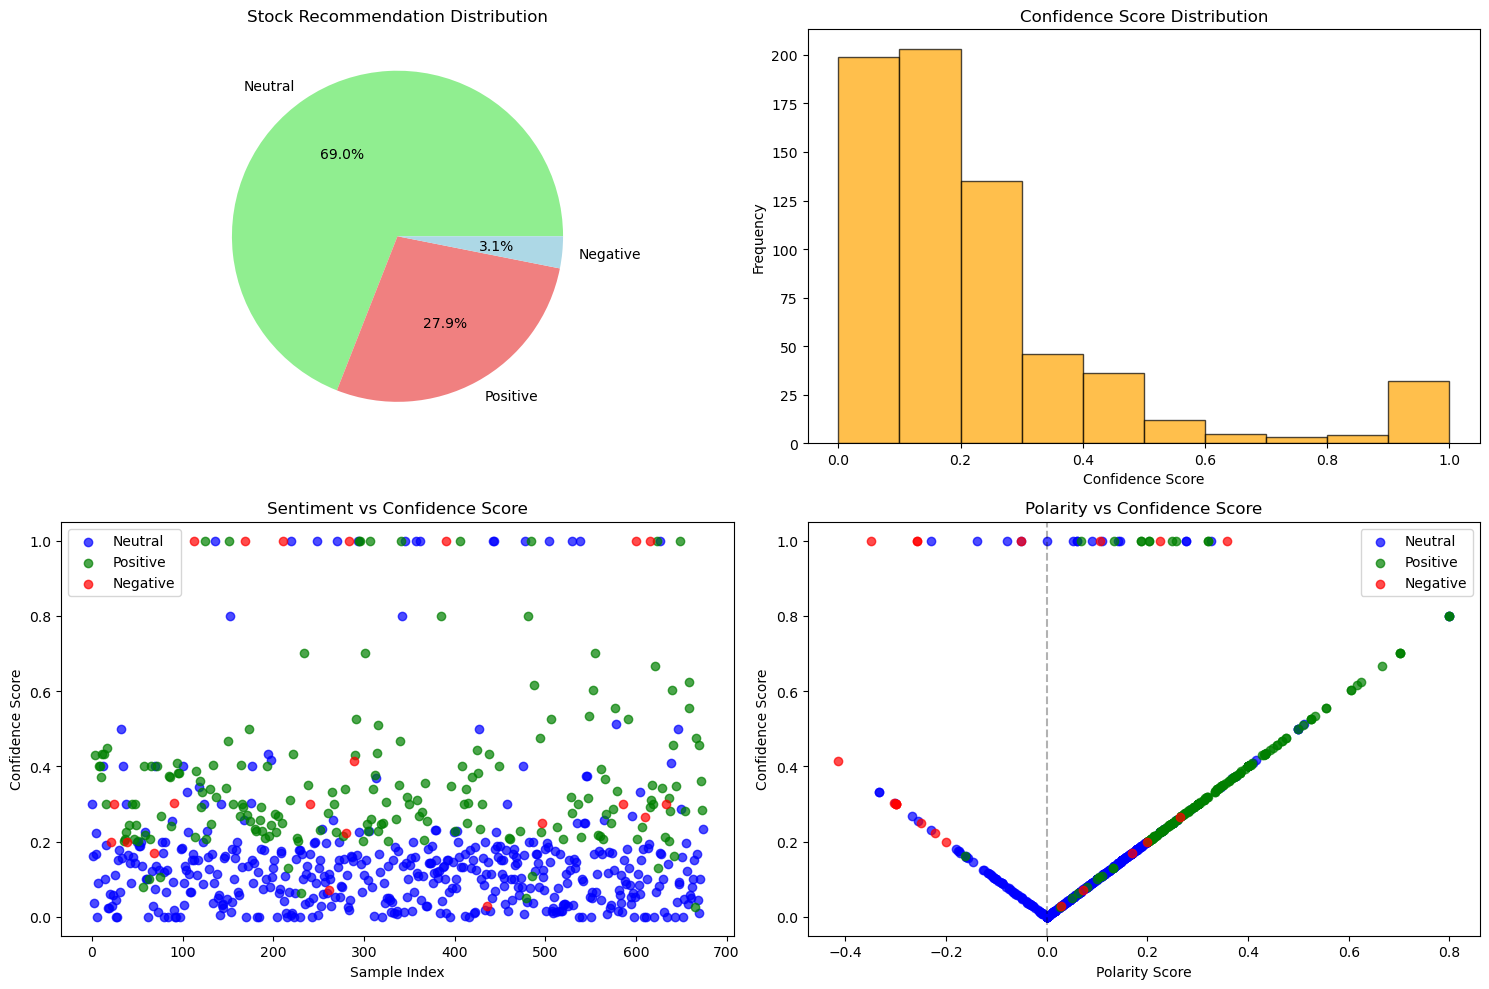

In [23]:
# Visualization
print("\n=== Creating Visualizations ===")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Sentiment Distribution Pie Chart
colors = ['lightgreen', 'lightcoral', 'lightblue']
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
               colors=colors)
axes[0, 0].set_title('Stock Recommendation Distribution')

# 2. Confidence Score Distribution
axes[0, 1].hist(df['confidence_score'], bins=10, color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Confidence Score Distribution')
axes[0, 1].set_xlabel('Confidence Score')
axes[0, 1].set_ylabel('Frequency')

# 3. Sentiment vs Confidence
sentiment_colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
for sentiment in df['stock_sentiment'].unique():
    subset = df[df['stock_sentiment'] == sentiment]
    axes[1, 0].scatter(subset.index, subset['confidence_score'], 
                      c=sentiment_colors[sentiment], label=sentiment, alpha=0.7)
axes[1, 0].set_title('Sentiment vs Confidence Score')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Confidence Score')
axes[1, 0].legend()

# 4. Polarity vs Confidence
for sentiment in df['stock_sentiment'].unique():
    subset = df[df['stock_sentiment'] == sentiment]
    axes[1, 1].scatter(subset['polarity_score'], subset['confidence_score'], 
                      c=sentiment_colors[sentiment], label=sentiment, alpha=0.7)
axes[1, 1].set_title('Polarity vs Confidence Score')
axes[1, 1].set_xlabel('Polarity Score')
axes[1, 1].set_ylabel('Confidence Score')
axes[1, 1].legend()
axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Save labeled dataset
print("\n=== Saving Labeled Dataset ===")
# Create output filename
output_filename = file_path.replace('.csv', '_labeled.csv') if 'your_file.csv' not in file_path else 'stock_sentiment_labeled.csv'

# Select columns to save (keep original columns + new sentiment columns)
columns_to_save = ['title', 'description', 'content', 'publishedAt', 'url', 
                   'stock_sentiment', 'confidence_score', 'polarity_score']
# Only include columns that exist in the dataframe
columns_to_save = [col for col in columns_to_save if col in df.columns]
df_output = df[columns_to_save].copy()

# Save to CSV
df_output.to_csv(output_filename, index=False)
print(f"Labeled dataset saved as: {output_filename}")
print(f"Columns saved: {columns_to_save}")


=== Saving Labeled Dataset ===
Labeled dataset saved as: ../Data/NLP/news_dataset_id2_labeled.csv
Columns saved: ['title', 'description', 'content', 'publishedAt', 'url', 'stock_sentiment', 'confidence_score', 'polarity_score']


In [25]:
# Summary statistics
print(f"\n=== Summary Statistics ===")
print(f"Total samples analyzed: {len(df)}")
print(f"Average confidence score: {df['confidence_score'].mean():.3f}")
print(f"Average polarity score: {df['polarity_score'].mean():.3f}")


=== Summary Statistics ===
Total samples analyzed: 675
Average confidence score: 0.219
Average polarity score: 0.149


In [26]:
# High confidence predictions
high_conf = df[df['confidence_score'] >= 0.7]
if len(high_conf) > 0:
    print(f"\nHigh confidence predictions (≥0.7): {len(high_conf)}")
    print("Sample high-confidence predictions:")
    for idx, row in high_conf.head(3).iterrows():
        title_preview = str(row.get('title', ''))[:50] + "..." if len(str(row.get('title', ''))) > 50 else str(row.get('title', ''))
        print(f"• {row['stock_sentiment']}: {title_preview} (Conf: {row['confidence_score']:.3f})")


High confidence predictions (≥0.7): 39
Sample high-confidence predictions:
• Negative: SpartanNash (NASDAQ:SPTN) Shares Gap Down on Disap... (Conf: 1.000)
• Positive: Russia boosts wheat exports to Africa as France lo... (Conf: 1.000)
• Neutral: $140 all-you-can-eat buffet worth it? Plus, travel... (Conf: 1.000)
